Purpose

Perform quick exploratory data analysis on cleaned app review data: basic stats, word frequency, and sentiment preview.

In [1]:
%pip install seaborn


Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import os
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Absolute paths
DATA_DIR = r"D:\PM\productivity-friction-insight-report\data\cleaned"
print("Loading data from:", DATA_DIR)


Loading data from: D:\PM\productivity-friction-insight-report\data\cleaned


Load cleaned app reviews

In [2]:
files = [f for f in os.listdir(DATA_DIR) if f.endswith("_cleaned.csv")]
print("Cleaned CSV files found:", files)

# Load into dict
app_dfs = {}
for file in files:
    app_name = file.split("_reviews")[0]
    df = pd.read_csv(os.path.join(DATA_DIR, file))
    app_dfs[app_name] = df
    print(f"{app_name}: {len(df)} reviews loaded")


Cleaned CSV files found: ['notion_reviews_cleaned.csv', 'slack_reviews_cleaned.csv', 'trello_reviews_cleaned.csv']
notion: 20 reviews loaded
slack: 20 reviews loaded
trello: 20 reviews loaded


In [3]:
for app, df in app_dfs.items():
    print(f"\n--- {app} ---")
    print("Average rating:", df['score'].mean())
    print("Min rating:", df['score'].min())
    print("Max rating:", df['score'].max())
    print("Number of unique reviews:", df['content'].nunique())



--- notion ---
Average rating: 3.75
Min rating: 1
Max rating: 5
Number of unique reviews: 20

--- slack ---
Average rating: 3.15
Min rating: 1
Max rating: 5
Number of unique reviews: 20

--- trello ---
Average rating: 3.8
Min rating: 1
Max rating: 5
Number of unique reviews: 20


Quick Stats per app

In [4]:
import pandas as pd
from datetime import datetime, timedelta

# Ensure your app dataframes are in app_dfs dictionary
summary_list = []

six_months_ago = datetime.now() - timedelta(days=180)

for app, df in app_dfs.items():
    # Ensure datetime
    df['at'] = pd.to_datetime(df['at'], errors='coerce')

    avg_rating = df['score'].mean()
    min_rating = df['score'].min()
    max_rating = df['score'].max()
    unique_reviews = df['content'].nunique()
    min_date = df['at'].min()
    max_date = df['at'].max()
    recent_reviews = df[df['at'] >= six_months_ago].shape[0]
    older_reviews = df[df['at'] < six_months_ago].shape[0]

    percent_recent = (recent_reviews / df.shape[0]) * 100 if df.shape[0] > 0 else 0

    summary_list.append({
        'App': app,
        'Avg Rating': avg_rating,
        'Min Rating': min_rating,
        'Max Rating': max_rating,
        'Unique Reviews': unique_reviews,
        'Earliest Review': min_date.date() if pd.notnull(min_date) else None,
        'Latest Review': max_date.date() if pd.notnull(max_date) else None,
        'Last 6 Months': recent_reviews,
        'Older Reviews': older_reviews,
        '% Recent Reviews': round(percent_recent, 2)
    })

# Create summary dataframe
summary_df = pd.DataFrame(summary_list)
summary_df


,App,Avg Rating,Min Rating,Max Rating,Unique Reviews,Earliest Review,Latest Review,Last 6 Months,Older Reviews,% Recent Reviews
0,notion,3.75,1,5,20,2025-11-30,2025-12-02,20,0,100.0
1,slack,3.15,1,5,20,2025-11-28,2025-12-02,20,0,100.0
2,trello,3.80,1,5,20,2025-11-04,2025-12-01,20,0,100.0


Top words / n-grams preview

In [5]:
import re

for app, df in app_dfs.items():
    all_text = " ".join(df['content'].astype(str)).lower()
    words = re.findall(r'\b\w+\b', all_text)
    most_common = Counter(words).most_common(15)
    print(f"\nTop words in {app}:", most_common)



Top words in notion: [('it', 16), ('i', 12), ('the', 10), ('and', 9), ('notion', 8), ('is', 7), ('my', 7), ('app', 7), ('can', 6), ('so', 6), ('to', 6), ('for', 6), ('a', 6), ('t', 6), ('but', 5)]

Top words in slack: [('the', 18), ('in', 8), ('a', 7), ('you', 6), ('and', 6), ('of', 6), ('for', 6), ('it', 5), ('s', 5), ('to', 5), ('app', 5), ('on', 4), ('my', 4), ('show', 4), ('as', 4)]

Top words in trello: [('the', 24), ('and', 19), ('to', 17), ('app', 12), ('a', 12), ('for', 11), ('i', 10), ('it', 8), ('of', 7), ('not', 7), ('my', 6), ('very', 6), ('in', 5), ('on', 5), ('is', 5)]


Stopword-cleaned Top Words for EDA.

In [9]:
# Define a basic set of English stop words
stop_words = set([
    "i", "me", "my", "myself", "we", "our", "ours", "ourselves",
    "you", "your", "yours", "yourself", "yourselves", "he", "him",
    "his", "himself", "she", "her", "hers", "herself", "it", "its",
    "itself", "they", "them", "their", "theirs", "themselves",
    "what", "which", "who", "whom", "this", "that", "these", "those",
    "am", "is", "are", "was", "were", "be", "been", "being",
    "have", "has", "had", "having", "do", "does", "did", "doing",
    "a", "an", "the", "and", "but", "if", "or", "because", "as",
    "until", "while", "of", "at", "by", "for", "with", "about",
    "against", "between", "into", "through", "during", "before",
    "after", "above", "below", "to", "from", "up", "down", "in",
    "out", "on", "off", "over", "under", "again", "further", "then",
    "once", "here", "there", "when", "where", "why", "how", "all",
    "any", "both", "each", "few", "more", "most", "other", "some",
    "such", "no", "nor", "not", "only", "own", "same", "so", "than",
    "too", "very", "s", "t", "can", "will", "just", "don", "should",
    "now"
])

top_n= 20


In [10]:
app_names = [app.lower() for app in app_dfs.keys()]  # ['notion', 'slack', 'trello']

for app, df in app_dfs.items():
    all_text = " ".join(df['content'].astype(str)).lower()
    words = re.findall(r'\b\w+\b', all_text)
    
    filtered_words = [w for w in words if w not in stop_words and w not in app_names]
    
    most_common = Counter(filtered_words).most_common(top_n)
    print(f"\nTop words in {app} (stopwords + app names removed):", most_common)



Top words in notion (stopwords + app names removed): [('app', 7), ('use', 4), ('persian', 4), ('data', 3), ('load', 3), ('life', 3), ('ai', 3), ('love', 3), ('great', 2), ('would', 2), ('give', 2), ('m', 2), ('working', 2), ('good', 2), ('work', 2), ('build', 2), ('better', 2), ('daily', 2), ('list', 2), ('business', 2)]

Top words in slack (stopwords + app names removed): [('app', 5), ('show', 4), ('channels', 3), ('well', 3), ('works', 3), ('work', 3), ('device', 2), ('sometimes', 2), ('used', 2), ('feature', 2), ('web', 2), ('keeps', 2), ('best', 2), ('great', 2), ('d', 2), ('fee', 2), ('re', 2), ('doesn', 2), ('unstable', 1), ('big', 1)]

Top words in trello (stopwords + app names removed): [('app', 12), ('keep', 4), ('would', 4), ('management', 4), ('way', 4), ('mobile', 4), ('use', 3), ('time', 3), ('add', 3), ('update', 3), ('web', 3), ('good', 3), ('helps', 2), ('great', 2), ('tasks', 2), ('projects', 2), ('makes', 2), ('every', 2), ('day', 2), ('organisation', 2)]


✅ What this does:

Counts the most frequent words after removing stopwords and app names.

Creates a horizontal bar chart for easy reading.

Gives you immediate insight into what users talk about most per app.

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


Prepare a plotting function


In [12]:
def plot_top_words(top_words, app_name, top_n=15):
    words, counts = zip(*top_words[:top_n])  # separate words and counts
    plt.figure(figsize=(10,5))
    sns.barplot(x=list(counts), y=list(words), palette="viridis")
    plt.title(f"Top {top_n} Words in {app_name} Reviews (Stopwords Removed)")
    plt.xlabel("Count")
    plt.ylabel("Word")
    plt.show()


Generate plots for each app

C:\Users\disha\AppData\Local\Temp\ipykernel_8548\2860495481.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="viridis")


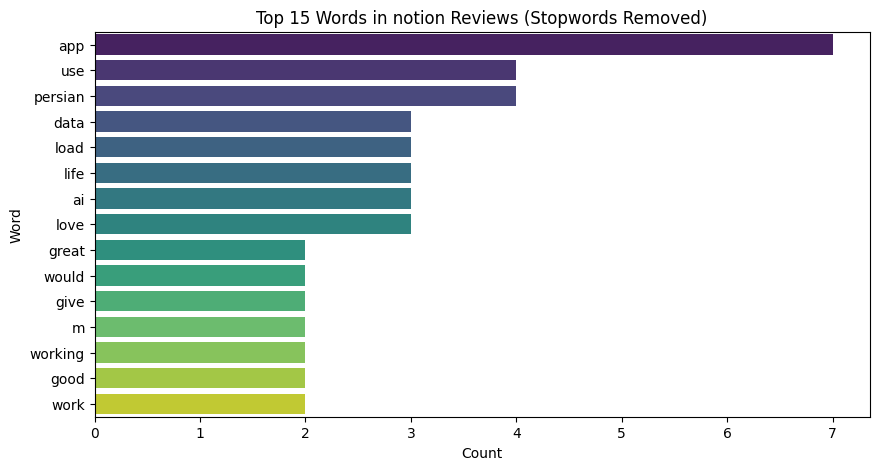

C:\Users\disha\AppData\Local\Temp\ipykernel_8548\2860495481.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="viridis")


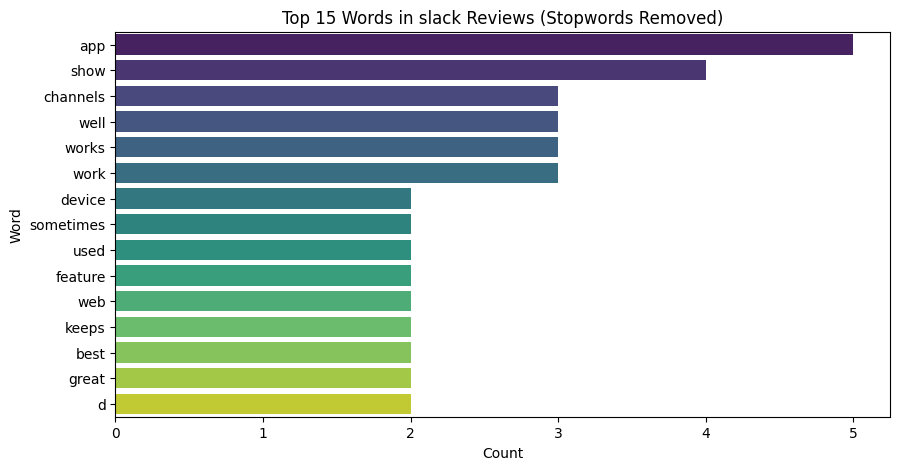

C:\Users\disha\AppData\Local\Temp\ipykernel_8548\2860495481.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="viridis")


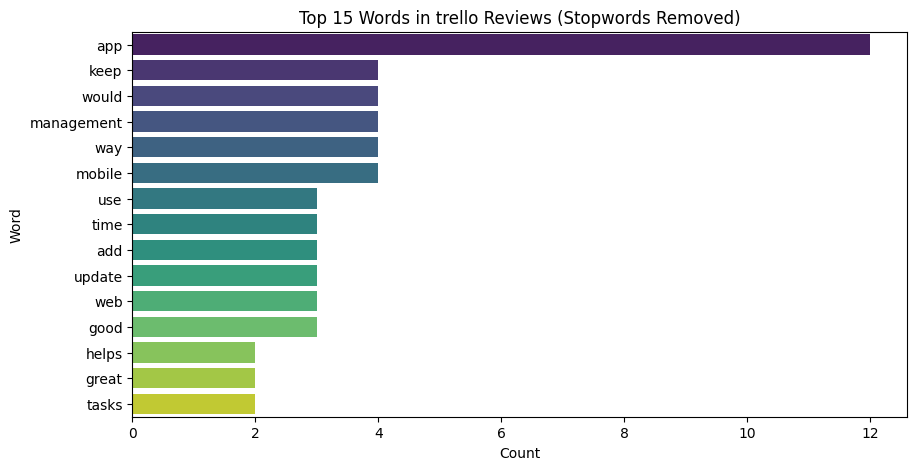

In [13]:
for app, df in app_dfs.items():
    all_text = " ".join(df['content'].astype(str)).lower()
    words = re.findall(r'\b\w+\b', all_text)
    filtered_words = [w for w in words if w not in stop_words and w not in app_names]
    most_common = Counter(filtered_words).most_common(15)
    
    plot_top_words(most_common, app)


Aggregate top words per app

In [14]:
import pandas as pd

top_n = 20
cross_app_words = []

for app, df in app_dfs.items():
    all_text = " ".join(df['content'].astype(str)).lower()
    words = re.findall(r'\b\w+\b', all_text)
    filtered_words = [w for w in words if w not in stop_words and w not in app_names]
    most_common = Counter(filtered_words).most_common(top_n)
    
    for word, count in most_common:
        cross_app_words.append({'app': app, 'word': word, 'count': count})

cross_df = pd.DataFrame(cross_app_words)


Pivot for visualization

In [18]:
pivot_df = cross_df.pivot_table(index='word', columns='app', values='count', fill_value=0)
pivot_df.head()
pivot_df = pivot_df.fillna(0).astype(int)




Plot a heatmap

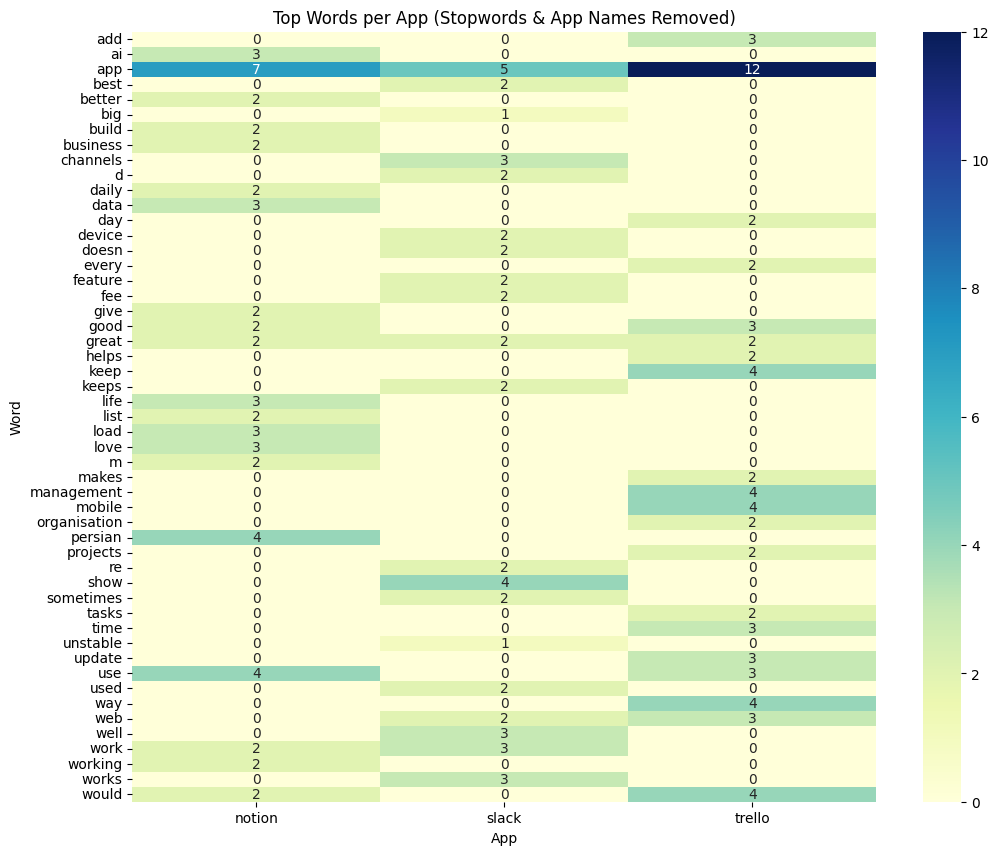

In [19]:
plt.figure(figsize=(12,10))
sns.heatmap(pivot_df, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Top Words per App (Stopwords & App Names Removed)")
plt.xlabel("App")
plt.ylabel("Word")
plt.show()
